## <font size=5> <strong> Groupe 4 - EI-2 DATA WEB - P\&G  </strong> </font>

* Sixtine Guerrand
* Antoine Pagneux
* Clément Lavenu
* Hector Bonnefoi
* Maxime Zennaro

## I. Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import os
print(os.listdir())

path="data/"

['.ipynb_checkpoints', 'Classification Binaire P&G.ipynb', 'data', 'Documents', 'README.md', 'requirements.txt']


## II. Importation et compréhension des jeux de données

In [2]:

def importation(filename):
    """ 
    Cette fontion permet d'importer et lire les différents fichiers .csv contenant les datasets
    :input: csv_file
        un dataset fourni
    :output: dataframe
        une représentation en tableau (dataframe) du dataset
    """
    return pd.read_csv(path+filename, sep=",")

#dataframe de soumission
sub_sample = importation("DS_Centrale_submission_sample.csv")

#dataframe de "actions des consommateurs"
cons_actions = importation("DS_CentraleSupelec_consumeractions.csv")

#dataframe des données à tester
test = importation("DS_CentraleSupelec_test.csv").fillna(0)

#dataframe des données d'entrainement
train = importation("DS_CentraleSupelec_train.csv").fillna(0)

#dataframe sur la dureté de l'eau en fonction du département (échelle : 1: eau douce,...,4:eau très dure)
df_dure = pd.read_csv(path+"eauxdures.csv",sep=";")

train.head()

,userId,age,gender,registrationDate,languageCode,countryCode,emailContactable,postalContactable,postalCode,numberChildren,...,detergentType,MrPropreTrier,AntikalTrier,ArielTrier,DashTrier,scentLover,petOwner,ecoInterest,closestShop,washDishes
0,use_XbA1FTDcCrTMNTHK1851TzjyPMP,24.0,F,2019-10-14T17:33:37Z,fr,FRA,True,True,68540,1,...,Liquid,0,0,0,0,NonUser,Yes,0,0,Auto
1,use_3WHgsMVGSg5MHG2zja91TzdfmY2,67.0,F,2017-07-25T07:00:31Z,fr,FRA,True,True,17390,3,...,Pods,Known Trier,Known Trier,Known Trier,0,0,No,High,0,Auto
2,use_2SisOiR8QwDaHI4svm11TzcvK7V,45.0,F,2015-06-25T00:00:00Z,fr,FRA,True,True,30200,1,...,Liquid,0,0,Known Trier,Known Trier,NonUser,Yes,High,0,Auto
3,use_W0T1LmfKaQPJYD1RTWh1Tzdc69H,35.0,F,2018-01-31T07:24:39Z,fr,FRA,True,True,61400,2,...,Pods,0,0,Known Trier,Known Trier,Low,Yes,Medium,0,Hand
4,use_KwYWZ7UMl4veveOaPGK1TzddtmI,38.0,F,2016-01-26T11:42:17Z,fr,FRA,True,True,30620,0,...,Liquid,Known Trier,Known Trier,Known Trier,Known Trier,0,Yes,Low,0,Hand


In [3]:
def score_event(event):
    """
    Cette fonction permet de mettre un score sur les différents types 
    d'évenement que l'on peut retrouver dans le dataset 'consumeractions'
    :input: str
        un évenement (email open, email clicked...)
    :output: int
        un score compris entre 1 et 7 associé à l'évenement
    """
    s=0
    tokens=event.split()
    if "Email" in tokens:
        if "Opened" in tokens:
            s=1
        #email clicked
        else:
            s=2
    if "Product" in tokens: #Product Reviewed
        s=3
    if "Search" in tokens: #Search site
        s=4
    if "Coupon" in tokens:
        if "Request" in tokens:
            if "Print" in tokens:
                s=6
            #Request Coupon Add-to-basket
            else:
                s=5
        else:
            s=7
    return s

In [4]:
def postal_code_rank(df):
    """
    Cette fonction permet de regrouper les villes d'un même département (via leur code posta)
    et classer ensuite les départements en fonction de leur fréquence d'appairtion dans les datasets
    :input: dataframe
        le dataframe avec la colonne 'postalCode'
    :output: list
        une liste avec les départements classés et leur fréquence associée (liste de tuples)
    """
    dic_CP={}
            
    for j in range(len(df)):
        cp=df.iloc[j]['postalCode']
        if cp=="Nimes":
            dep=30
        else:
            dep=int(float(str(cp)[:2]))
            
        if dep in dic_CP:
            dic_CP[dep]+=1
        else:
            dic_CP[dep]=0
    
    return dic_CP

In [5]:
#mots clés associés au lave-vaisselle
key_words=['Fairy','PEPS','Platinum+']

In [22]:

# N.B : Cette fonction peut prendre 5-10 minutes pour calculer du fait du croisement avec le dataset 'consumeractions' 
# qui fait près de 1 millions de lignes pour les événements 

def clean_df_to_num(df_train,df_cons_act,data_type,filename,added_filters):
    """
    Cette fonction permet de générer un dataframe avec des données numériques 
    en appliquant différentes métriques pour chaque feature
    :input: dataframe, dataframe, str
        nous avons comme entrées, le dataframe à transformer numériquemement, le dataset 'consumeractions' 
        et savoir il s'agit de données d'entrainement ou de tests. Cette dernière options sert à juste nous dire 
        si on doit laisser la colonne 'washDishes' ou pas (dans le cas du dataset de test on l'enlève)
    :output: dataframe
        un score compris entre 1 et 7 associé à l'évenement
    """

    df_num=df_train[['age']]

    filters=['languageCode','countryCode','lastActivityDate','closestShop','registrationDate','detergentType']

    feature_names=df_train.keys()[1:]
    # print(feature_names)
    for col in feature_names:
        if str(col) not in filters:
            df_num[col]=0
    for coll in ['liquidDetergent','podsDetergent','powderDetergent','pc_score','postalScore']:
        df_num[coll]=0
    
    #création de moyenne d'âge
    for i in range(len(df_train)):
        value=df_train.iloc[i]['age']
        if 10<=value<20:
            value=15
        if 20<=value<30:
            value=25
        if 30<=value<40:
            value=35
        if 40<=value<50:
            value=45
        if 50<=value<60:
            value=55
        if 60<=value<70:
            value=65
        if 70<=value<80:
            value=75
        if 80<=value<=90:
            value=85
        df_num.at[i,'age']=value
    
    df_num['score_event']=0
    
    #on garde la variable explicative pour l'entrainement
    if data_type=="training":
        df_num.loc[df_train.washDishes=="Auto",'washDishes']=1

    #on affecte nos métriques (binaire, échelle d'intensité de 1 à 4 ...)
    
    df_num.loc[df_train.gender=="F",'gender']=1
    df_num.loc[df_train.gender=="M",'gender']=0


    df_num.loc[df_train.ecoInterest=="Low",'ecoInterest']=1
    df_num.loc[df_train.ecoInterest=="Medium",'ecoInterest']=2
    df_num.loc[df_train.ecoInterest=="High",'ecoInterest']=3
    df_num.loc[df_train.ecoInterest=="Very high",'ecoInterest']=4


    df_num.loc[df_train.petOwner=="Yes",'petOwner']=1


    df_num.loc[df_train.MrPropreTrier=="Known Trier",'MrPropreTrier']=1
    df_num.loc[df_train.AntikalTrier=="Known Trier",'AntikalTrier']=1
    df_num.loc[df_train.ArielTrier=="Known Trier",'ArielTrier']=1
    df_num.loc[train.DashTrier=="Known Trier",'DashTrier']=1


    df_num.loc[df_train.toothBrushType=="Manual",'toothBrushType']=0
    df_num.loc[df_train.toothBrushType=="Electric",'toothBrushType']=1


    df_num.loc[df_train.emailContactable==True,'emailContactable']=1
    df_num.loc[df_train.postalContactable==True,'postalContactable']=1


    for i in range(17):
        
        if i < 5:
            df_num.loc[df_train.numberChildren==str(i),'numberChildren']=i

        else:
            df_num.loc[df_train.numberChildren==str(i),'numberChildren']=5

            
    df_num.loc[df_train.numberChildren=="4+",'numberChildren']=5
    df_num['numberChildren'] = pd.to_numeric(df_num['numberChildren'])

    
    df_num.loc[df_train.reactivationValue=="Lapsed",'reactivationValue']=3
    df_num.loc[df_train.reactivationValue=="Lapsing",'reactivationValue']=2
    df_num.loc[df_train.reactivationValue=="Dormant",'reactivationValue']=1
    df_num.loc[df_train.reactivationValue=="Active",'reactivationValue']=4


    df_num.loc[df_train.scentLover=="NonUser",'scentLover']=0
    df_num.loc[df_train.scentLover=="Low",'scentLover']=1
    df_num.loc[df_train.scentLover=="Medium",'scentLover']=2
    df_num.loc[df_train.scentLover=="High",'scentLover']=3



    for j in range(len(df_train)):
        cp=str(df_train.iloc[j]['postalCode'])
        
        # cas ou trouve le nom d'une ville dans code postal
        if cp=="Nimes":
            dep=30
        else:
            #département à un chiffre
            if len(cp)==4:
                dep=int(str(cp)[0])
            else:
                dep=int(str(cp)[:2])
            
            
        df_num.at[j,'postalCode']=dep
     
    
    dic_rank=postal_code_rank(df_num)
    
    for key in dic_rank:
        df_num.loc[df_num.postalCode==key,'postalScore']=dic_rank[key]
        
    
    
    # création de la colonne de la dureté de l'eau (new feature) en fonction du département
    for i in range(len(df_num)):
        
        dep=str(df_num["postalCode"][i])

        try:
            df_num['pc_score'][i]=df_dure[df_dure['Département']==dep].iloc[0]['Dureté']
        except:
            df_num['pc_score'][i]=0
    
    #on crée 3 colonnes différentes pour chaque type de détergents et on applique une métrique binaire
    for i in range(len(df_train)):
        value=df_train.iloc[i]['detergentType']
        if value!=0:
            value1=value.split(',')

            val_pods=0
            val_liq=0
            val_powd=0

            if 'Pods' in value1:
                val_pods=1
            if 'Liquid' in value1:
                val_liq=1
            if 'Powder' in value1:
                val_powd=1
                
            df_num.at[i,'liquidDetergent']=val_liq
            df_num.at[i,'podsDetergent']=val_pods
            df_num.at[i,'powderDetergent']=val_powd
            
            
    ## on rajoute une feature du dataset 'consumeractions'
    
    liste_userID=df_train['userId'].unique()
    dic_events={}
    
    for userId in liste_userID:
        dic_events[userId]=0
        
    df=df_cons_act    
    
    # on regarde si nous avons des mots clés sur les laves-vaisselles (les key-words plus haut) ject line'
    # et on regarde les évènements associés puis on attribut un score global par utilisateur
    for i in range(len(df)): 
        bd=df.iloc[i]['brandName']
        subject=df.iloc[i]['subjectLine']
        
        status=False
        try:
            if any(word in bd.split() for word in key_words) :
                status=True
        except:
            None
        try:
            if any(word in subject.split() for word in key_words):
                status=True
        except:
            None
        if status==True:
            try:
                dic_events[df.iloc[i]['userId']] += score_event(df.iloc[i]['event'])      
                
            except:
                None
         
    for i in range(len(df_num)):
        
        keyID=df_train.iloc[i]['userId']
        if keyID in dic_events:
            df_num.at[i,'score_event']=dic_events[keyID]
    
    
    f = open(filename, 'r+')
    f.truncate(0)
    df_num.drop(added_filters,axis=1).to_csv(filename)


In [7]:
##### N.B1 : N'exécuter cette cellule que s'ils faut mettre à jour le dataset d'entrainement    #####
# par exemple, s'il y a eu un changement de métrique, une feature rajoutée...
# Exécuter uniquement la cellule suivante qui va importer le dataset numérique générée par la cellule actuelle

clean_df_to_num(train,cons_actions,"training",path+'DS_num_train.csv',[])

<ipython-input-6-021a333ebf36>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col]=0
<ipython-input-6-021a333ebf36>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[coll]=0
<ipython-input-6-021a333ebf36>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-6-021a333ebf36>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.loc[df_num.postalCode==key,'postalScore']=dic_rank[key]
<ipython-input-7-9470a7187ab9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_to_num(train,cons_actions,"training",path+'DS_num_train.csv',[])


In [7]:
#dataframe numérique sur les données d'entrainement
df_num=importation("DS_num_train.csv")
df_num.head()

,Unnamed: 0,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,...,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,postalScore,score_event
0,0,25,1,1,1,68,1,2,0,0,...,0,1,0,1,1,0,0,2,113,0
1,1,65,1,1,1,17,3,4,0,1,...,0,0,3,1,0,1,0,3,106,1
2,2,45,1,1,1,30,1,4,0,0,...,0,1,3,1,1,0,0,3,124,0
3,3,35,1,1,1,61,2,4,0,0,...,1,1,2,0,0,1,0,3,70,0
4,4,35,1,1,1,30,0,4,1,1,...,0,1,1,0,1,0,0,3,124,0


#### Taille du dataset

In [8]:
df_num.shape

(12000, 23)

#### Affichage de certaines lignes

In [9]:
df_num.sample(5)

,Unnamed: 0,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,...,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,postalScore,score_event
11501,11501,45,1,1,1,26,0,4,1,1,...,3,0,2,1,0,0,0,3,70,0
2363,2363,45,1,1,1,44,0,4,0,0,...,0,1,2,1,0,1,0,2,260,2
6871,6871,55,1,1,1,59,1,4,0,0,...,0,1,3,1,1,0,0,4,808,0
10905,10905,35,1,1,1,67,1,4,0,1,...,1,0,0,0,0,1,0,2,169,0
9805,9805,35,1,1,1,18,2,4,1,0,...,0,1,2,1,0,1,0,2,63,1


#### Description

In [11]:
df_num.describe()

,Unnamed: 0,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,...,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,postalScore,score_event
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,40.678417,0.866083,0.880167,0.89400,51.768583,1.275583,3.369667,0.340333,0.171000,...,0.529750,0.600417,1.370083,0.382000,0.500583,0.348083,0.037750,2.581667,231.882167,0.682833
std,3464.24595,14.446351,0.340577,0.324780,0.30785,26.970517,1.294454,1.057090,0.473841,0.376525,...,0.912607,0.489833,1.314065,0.485897,0.500020,0.476382,0.190599,1.075683,199.990994,1.905748
min,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,2999.75000,35.000000,1.000000,1.000000,1.00000,31.000000,0.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,107.000000,0.000000
50%,5999.50000,35.000000,1.000000,1.000000,1.00000,58.000000,1.000000,4.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,188.000000,0.000000
75%,8999.25000,45.000000,1.000000,1.000000,1.00000,74.000000,2.000000,4.000000,1.000000,0.000000,...,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,3.000000,242.000000,0.000000
max,11999.00000,95.000000,1.000000,1.000000,1.00000,98.000000,5.000000,4.000000,1.000000,1.000000,...,3.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,808.000000,47.000000


In [12]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Unnamed: 0         12000 non-null  int64
 1   age                12000 non-null  int64
 2   gender             12000 non-null  int64
 3   emailContactable   12000 non-null  int64
 4   postalContactable  12000 non-null  int64
 5   postalCode         12000 non-null  int64
 6   numberChildren     12000 non-null  int64
 7   reactivationValue  12000 non-null  int64
 8   toothBrushType     12000 non-null  int64
 9   MrPropreTrier      12000 non-null  int64
 10  AntikalTrier       12000 non-null  int64
 11  ArielTrier         12000 non-null  int64
 12  DashTrier          12000 non-null  int64
 13  scentLover         12000 non-null  int64
 14  petOwner           12000 non-null  int64
 15  ecoInterest        12000 non-null  int64
 16  washDishes         12000 non-null  int64
 17  liquidDeterg

#### Analyse de la variable à expliquer

In [13]:
df_num["washDishes"].describe()

count    12000.000000
mean         0.382000
std          0.485897
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: washDishes, dtype: float64

In [14]:
df_num["washDishes"].unique()

array([1, 0], dtype=int64)

### Corrélation des features

In [15]:
print(df_num.corr()["washDishes"].abs().sort_values(ascending=False))

washDishes           1.000000
numberChildren       0.154992
age                  0.153612
toothBrushType       0.111456
ecoInterest          0.109189
score_event          0.099711
petOwner             0.097935
reactivationValue    0.092396
postalContactable    0.082962
postalScore          0.077483
emailContactable     0.073574
podsDetergent        0.048025
gender               0.047276
scentLover           0.038834
ArielTrier           0.034418
AntikalTrier         0.026565
DashTrier            0.021948
postalCode           0.020273
MrPropreTrier        0.017828
pc_score             0.014453
Unnamed: 0           0.011538
liquidDetergent      0.008464
powderDetergent      0.004458
Name: washDishes, dtype: float64


## Analyse des données

### Analyse de la variable 'washDishes'

0    7416
1    4584
Name: washDishes, dtype: int64


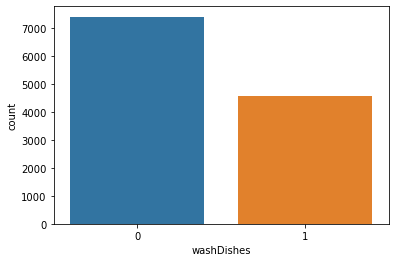

In [16]:
y = df_num["washDishes"]

sns.countplot(y)

target_temp = df_num.washDishes.value_counts()

print(target_temp)

In [17]:
print("Pourcentage de personnes lavant sa vaisselle à la main"+str(round(target_temp[0]*100/12000,2)))
print("Pourcentage de personnes ayant un lave-vaisselle "+str(round(target_temp[1]*100/12000,2)))


Pourcentage de personnes lavant sa vaisselle à la main61.8
Pourcentage de personnes ayant un lave-vaisselle 38.2


### Analyse de la feature 'âge'

In [18]:
df_num["age"].unique()

array([25, 65, 45, 35, 55, 75,  0, 85, 15, 95, 91, 93, 94], dtype=int64)

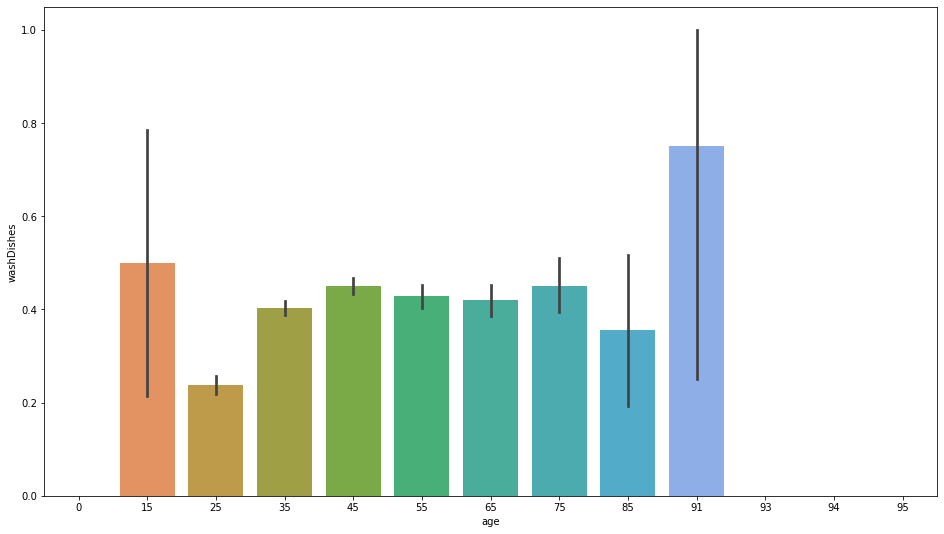

In [19]:
plt.figure(figsize=(16,9))
sns.barplot(df_num["age"],y)

### Analyse de la feature 'ecoInterest'

In [20]:
df_num["ecoInterest"].unique()

array([0, 3, 2, 1, 4], dtype=int64)

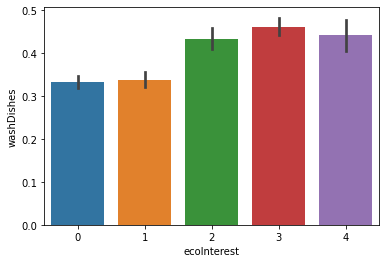

In [21]:
sns.barplot(df_num["ecoInterest"],y)

##### We notice, that chest pain of '0', i.e. the ones with typical angina are much less likely to have heart problems

### Analyse de la feature 'gender'

In [22]:
df_num["gender"].unique()

array([1, 0], dtype=int64)

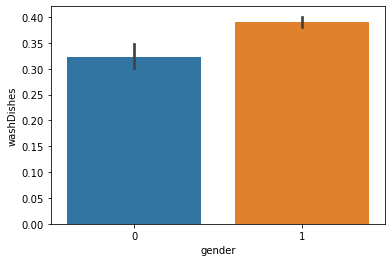

In [23]:
sns.barplot(df_num["gender"],y)

### Analyse de la feature 'toothBrushType'

In [24]:
df_num["toothBrushType"].unique()

array([0, 1], dtype=int64)

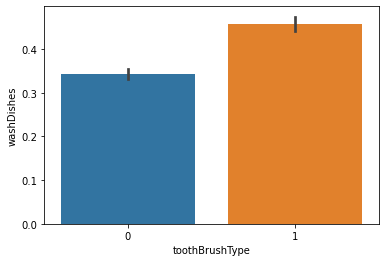

In [25]:
sns.barplot(df_num["toothBrushType"],y)

### Analyse de la feature 'reactivationValue'

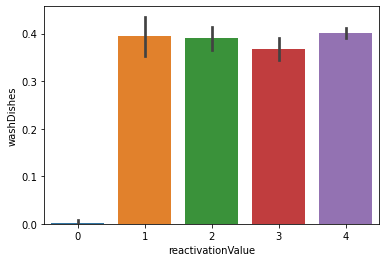

In [26]:
df_num["reactivationValue"].unique()
sns.barplot(df_num["reactivationValue"],y)

### Analyse de la feature 'postalCode' avec département uniquement

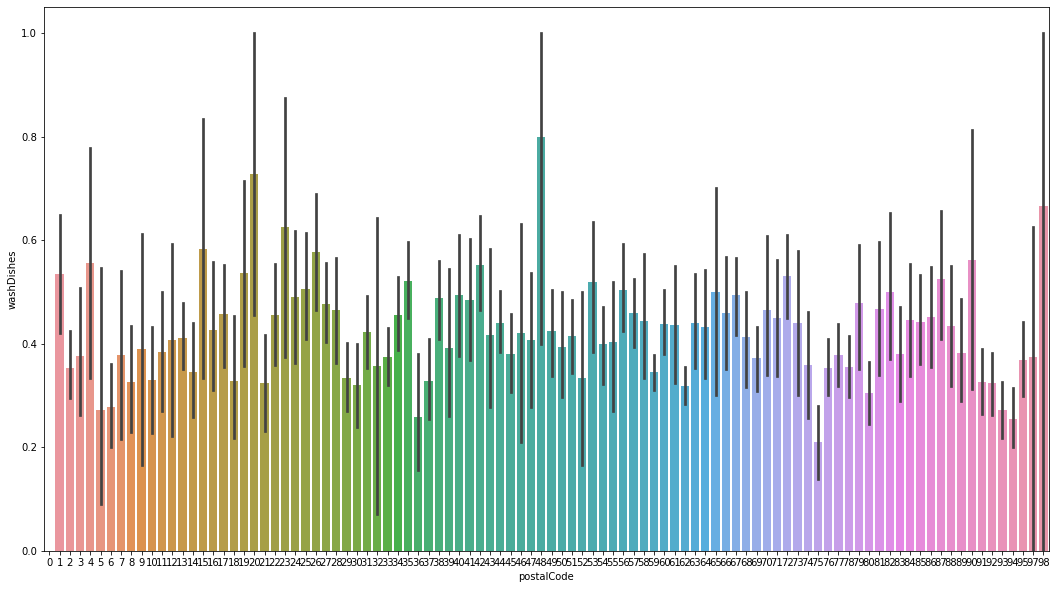

In [27]:
df_num["postalCode"].unique()
plt.figure(figsize=(18,10))
sns.barplot(df_num["postalCode"],y)

## IV. Phase d'apprentissage

In [23]:
from sklearn.model_selection import train_test_split

#filtres = features non utilisés
filters=['scentLover','ArielTrier' ,'AntikalTrier','DashTrier' ,'MrPropreTrier','postalCode','liquidDetergent','powderDetergent']

# données d'entrainements
predictors = df_num.drop(filters+['washDishes'],axis=1)
target = df_num["washDishes"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)


In [24]:
X_train.shape

(9600, 11)

In [25]:
X_test.shape

(2400, 11)

In [26]:
Y_train.shape

(9600,)

In [27]:
Y_test.shape

(2400,)

In [28]:
##### N.B : N'exécuter cette cellule que si vous avait chnagé les filtres car le calcul prend aussi entre 5-10 minutes. #####

# dataset de tests (qui sera à soumettre)
clean_df_to_num(test,cons_actions,"test",path+'DS_num_test.csv',filters)

<ipython-input-22-ebdf7a00d565>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col]=0
<ipython-input-22-ebdf7a00d565>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[coll]=0
<ipython-input-22-ebdf7a00d565>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

<ipython-input-22-ebdf7a00d565>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.loc[df_num.postalCode==key,'postalScore']=dic_rank[key]
<ipython-input-28-cf01da464438>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_to_num(test,cons_actions,"test",path+'DS_num_test.csv',filters)


In [29]:
# dataset de tests directement utilisable
df_test=importation("DS_num_test.csv").fillna(0)
df_test.head()

,Unnamed: 0,age,emailContactable,postalContactable,numberChildren,reactivationValue,toothBrushType,petOwner,ecoInterest,postalScore,score_event
0,0,35,1,1,5,4,0,0,3,325,0
1,1,45,1,1,2,2,0,1,3,65,0
2,2,25,0,1,1,4,0,1,0,179,0
3,3,65,1,1,3,4,0,0,0,53,4
4,4,45,1,1,2,4,0,1,2,95,7


In [16]:
def generate_csv_submission(filename, Y):
    """
    Cette fonction permet de générer un fichier csv contenant les résultats obtenus 
    afin de les soumettre sur Kaggle au bon format
    :input: file, array
        fichier sur lequel écrire, listes des résultats prédits (Y)
    :output: None
        création du fichier résultat dans le répertoire "data"
    """
    file = open(filename + ".csv", 'w')
    with open("data/DS_Centrale_submission_sample.csv", 'r') as filin:
        i = 0
        line = filin.readline()
        file.write(line)
        while line != "" and i < len(Y):
            line = filin.readline()
            line_splited = line.split(",")
            if Y[i] == 0:
                line_splited[1] = 'Hand\n'
            new_line = line_splited[0] + "," + line_splited[1]
            file.write(new_line) 
            i += 1
        file.close()       




## V. Modèle statistiques utilisés

In [62]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
import collections

### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,Y_train)

Y_pred_lr = lr.predict(X_test)

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
Y_pred_lr.shape

(2400,)

In [97]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)
print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")
precision_lr=round(precision_score(Y_pred_lr,Y_test)*100,2)
print("The precision score achieved using Logistic Regression is: "+str(precision_lr)+" %")
recall_lr=round(recall_score(Y_pred_lr,Y_test)*100,2)
print("The recall score achieved using Logistic Regression is: "+str(recall_lr)+" %")
F1_lr=round(f1_score(Y_pred_lr,Y_test)*100,2)
print("The f1 score achieved using Logistic Regression is: "+str(F1_lr)+" %")
conf = confusion_matrix(Y_test,Y_pred_lr )
print(conf)

The accuracy score achieved using Logistic Regression is: 64.21 %
The precision score achieved using Logistic Regression is: 26.64 %
The recall score achieved using Logistic Regression is: 54.32 %
The f1 score achieved using Logistic Regression is: 35.75 %
[[1302  201]
 [ 658  239]]


In [35]:
df_test.shape
Y_real_lr = lr.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ",collections.Counter(Y_real_lr))


Counter({0: 2722, 1: 1278})


In [100]:
# génération du fichier csv
#generate_csv_submission("data/test_lr", Y_real_lr)

### Naive Bayes

In [66]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,Y_train)

Y_pred_nb = nb.predict(X_test)
Y_pred_nb.shape

(2400,)

In [98]:
score_nb = round(accuracy_score(Y_pred_nb,Y_test)*100,2)
print("The accuracy score achieved using Naive Bayse is: "+str(score_nb)+" %")
precision_nb=round(precision_score(Y_pred_nb,Y_test)*100,2)
print("The precision score achieved using Naive Bayse is: "+str(precision_nb)+" %")
recall_nb=round(recall_score(Y_pred_nb,Y_test)*100,2)
print("The recall score achieved using Naive Bayse is: "+str(recall_nb)+" %")
F1_nb=round(f1_score(Y_pred_nb,Y_test)*100,2)
print("The f1 score achieved using Naive Bayse is: "+str(F1_nb)+" %")
conf = confusion_matrix(Y_test,Y_pred_nb )
print(conf)

The accuracy score achieved using Naive Bayse is: 62.42 %
The precision score achieved using Naive Bayse is: 43.92 %
The recall score achieved using Naive Bayse is: 49.68 %
The f1 score achieved using Naive Bayse is: 46.63 %
[[1104  399]
 [ 503  394]]


In [68]:
df_test.shape
Y_real_nb = nb.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ",collections.Counter(Y_real_nb))


Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 2473, 1: 1527})


In [104]:
# Génération du fichier csv
#generate_csv_submission("data/test_nb", Y_real_nb)

### SVM

In [69]:
from sklearn import svm

sv = svm.SVC(kernel='rbf')
sv.fit(X_train, Y_train)
Y_pred_svm = sv.predict(X_test)

In [70]:
Y_pred_svm.shape

(2400,)

In [103]:
score_svm = round(accuracy_score(Y_pred_svm,Y_test)*100,2)
print("The accuracy score achieved using rbf SVM is: "+str(score_svm)+" %")
precision_svm=round(precision_score(Y_pred_svm,Y_test)*100,2)
print("The precision score achieved using rbf SVM is: "+str(precision_svm)+" %")
recall_svm=round(recall_score(Y_pred_svm,Y_test)*100,2)
print("The recall score achieved using rbf SVM is: "+str(recall_svm)+" %")
F1_svm=round(f1_score(Y_pred_svm,Y_test)*100,2)
print("The f1 score achieved using rbf SVM is: "+str(F1_svm)+" %")
conf = confusion_matrix(Y_test,Y_pred_svm )
print(conf)

The accuracy score achieved using rbf SVM is: 62.62 %
The precision score achieved using rbf SVM is: 0.0 %
The recall score achieved using rbf SVM is: 0.0 %
The f1 score achieved using rbf SVM is: 0.0 %
[[1503    0]
 [ 897    0]]


D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
df_test.shape
Y_real_svm = sv.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ", collections.Counter(Y_real_svm))

Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 4000})


### K Nearest Neighbors

In [73]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,Y_train)
Y_pred_knn=knn.predict(X_test)

In [74]:
Y_pred_knn.shape

(2400,)

In [102]:
score_knn = round(accuracy_score(Y_pred_knn,Y_test)*100,2)
print("The accuracy score achieved using KNN is: "+str(score_knn)+" %")
precision_knn=round(precision_score(Y_pred_knn,Y_test)*100,2)
print("The precision score achieved using KNN is: "+str(precision_knn)+" %")
recall_knn=round(recall_score(Y_pred_knn,Y_test)*100,2)
print("The recall score achieved using KNN is: "+str(recall_knn)+" %")
F1_knn=round(f1_score(Y_pred_knn,Y_test)*100,2)
print("The f1 score achieved using KNN is: "+str(F1_knn)+" %")
conf = confusion_matrix(Y_test,Y_pred_knn )
print(conf)

The accuracy score achieved using KNN is: 59.71 %
The precision score achieved using KNN is: 17.5 %
The recall score achieved using KNN is: 40.89 %
The f1 score achieved using KNN is: 24.51 %
[[1276  227]
 [ 740  157]]


### Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
# Optimisation des hyperparamètres à l'aide de l'outil GridSearchCV
# NE PAS EXECUTER - 2h-3h
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100, 110],
    'max_features': [2, 3, 4, 5, 6],
    'min_samples_leaf': [10, 20, 30, 40],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': np.arange(80, 240, 20)
}# Create a based model

rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

tests d'optimisation :
test1
param_grid = { 'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 5, 8, 12 ], 'min_samples_split': [10, 12, 14], 'n_estimators': [10, 100, 200] }# Create a based model

{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 200}

test2
param_grid = { 'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [8, 12, 15, 20 ], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300] }# Create a based model

{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 20, 'min_samples_split': 8, 'n_estimators': 100}

rfc = RandomForestClassifier(n_estimators=100, min_samples_leaf = 20, min_samples_split = 8, max_features = 2, max_depth = 80)

Accuracy: 0.6491666666666667 Mean Absolute Error: 0.35083333333333333 Mean Squared Error: 0.35083333333333333 Root Mean Squared Error: 0.5923118547972287

test 3
param_grid = { 'bootstrap': [True], 'max_depth': [70, 80, 90, 100, 110], 'max_features': [1, 2, 3, 4], 'min_samples_leaf': [10, 15, 20, 25, 30], 'min_samples_split': [6, 8, 10, 12], 'n_estimators': [20, 50, 100, 200, 300] }# Create a based model

{'bootstrap': True, 'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 30, 'min_samples_split': 10, 'n_estimators': 200}

rfc = RandomForestClassifier(n_estimators=200, min_samples_leaf = 30, min_samples_split = 10, max_features = 2, max_depth = 90)

Accuracy: 0.6458333333333334 Mean Absolute Error: 0.3541666666666667 Mean Squared Error: 0.3541666666666667 Root Mean Squared Error: 0.5951190357119042

test 4
param_grid = { 'bootstrap': [True], 'max_depth': [70, 80, 90, 100, 110], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [10, 20, 30, 40], 'min_samples_split': [6, 8, 10, 12], 'n_estimators': [20, 50, 100, 200, 300] }# Create a based model

{'bootstrap': True, 'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 12, 'n_estimators': 180}

In [104]:
rfc = RandomForestClassifier(n_estimators=180, min_samples_leaf = 10, min_samples_split = 12, max_features = 4, max_depth = 90)
rfc.fit(X_train,Y_train)
y_pred_rfc =  rfc.predict(X_test)

score_rf=round(metrics.accuracy_score(Y_test, y_pred_rfc)*100,2)
print("Accuracy:",score_rf)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_rfc))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_rfc))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_rfc)))

print("The accuracy score achieved using Random Forest is: "+str(score_rf)+" %")
precision_rf=round(precision_score(y_pred_rfc,Y_test)*100,2)
print("The precision score achieved using Random Forest is: "+str(precision_rf)+" %")
recall_rf=round(recall_score(y_pred_rfc,Y_test)*100,2)
print("The recall score achieved using Random Forest is: "+str(recall_rf)+" %")
F1_rf=round(f1_score(y_pred_rfc,Y_test)*100,2)
print("The f1 score achieved using Random Forest is: "+str(F1_rf)+" %")
conf = confusion_matrix(Y_test,y_pred_rfc )
print(conf)

Accuracy: 65.04
Mean Absolute Error: 0.34958333333333336
Mean Squared Error: 0.34958333333333336
Root Mean Squared Error: 0.5912557258355587
The accuracy score achieved using Random Forest is: 65.04 %
The precision score achieved using Random Forest is: 29.65 %
The recall score achieved using Random Forest is: 56.12 %
The f1 score achieved using Random Forest is: 38.8 %
[[1295  208]
 [ 631  266]]


In [78]:
# Calcul sur l'échantillon de test
Y_test_pred_rf = rfc.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ",collections.Counter(Y_test_pred_rf))

# Génération du fichier CSV
generate_csv_submission("data/randomforest_gridsearchcv_12feats_eaudures_22", Y_test_pred_rf)

Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 2643, 1: 1357})


### XGBoost

In [79]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
# Optimisation des hyperparamètres à l'aide de l'outil GridSearchCV
# NE PAS EXECUTER - 10h

estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
)


parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'seed' : np.arange(30,50,2),
    'nthread' : np.arange(2,6,1)
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, Y_train)


print(grid_search.best_estimator_)
print(grid_search.best_params_)

* test1

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(100, 1000, 50),
    'learning_rate': [0.1, 0.01, 0.05]
}

{'colsample_bytree': 0.72, 'eta': 0.1, 'gamma': 5, 'min_child_weight': 4.0, 'subsample': 0.72}

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'nthread': 2, 'seed': 30}

In [80]:
xgb_model = xgb.XGBClassifier(objective= 'binary:logistic',
    nthread=2,
    seed=42,
    colsample_bytree = 0.72,
    eta = 0.1,
    gamma = 5,
    min_child_weight = 4.0,
    subsample = 0.72,
    max_depth = 3,
    n_estimator = 100,
    learning_rate = 0.05
)

xgb_model.fit(X_train, Y_train)

Y_pred_xgb = xgb_model.predict(X_test)
Y_pred_xgb.shape

D:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:58:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(2400,)

In [105]:
score_xgb = round(accuracy_score(Y_pred_xgb,Y_test)*100,2)
print("The accuracy score achieved using XGBoost is: "+str(score_xgb)+" %")
precision_xgb=round(precision_score(Y_pred_xgb,Y_test)*100,2)
print("The precision score achieved using XGBoost is: "+str(precision_xgb)+" %")
recall_xgb=round(recall_score(Y_pred_xgb,Y_test)*100,2)
print("The recall score achieved using XGBoost is: "+str(recall_xgb)+" %")
F1_xgb=round(f1_score(Y_pred_xgb,Y_test)*100,2)
print("The f1 score achieved using XGBoost is: "+str(F1_xgb)+" %")
conf = confusion_matrix(Y_test,Y_pred_xgb )
print(conf)



print(collections.Counter(Y_pred_xgb))

Y_test_pred_xgb = xgb_model.predict(df_test)
print(confusion_matrix(Y_test, Y_pred_xgb))
print(collections.Counter(Y_test_pred_xgb))

# Génération des fichiers csv
generate_csv_submission("data/xgboost_12feats_xgboost_22", Y_test_pred_xgb)

The accuracy score achieved using XGBoost is: 65.58 %
The precision score achieved using XGBoost is: 27.09 %
The recall score achieved using XGBoost is: 58.55 %
The f1 score achieved using XGBoost is: 37.04 %
[[1331  172]
 [ 654  243]]
Counter({0: 1985, 1: 415})
[[1331  172]
 [ 654  243]]
Counter({0: 2805, 1: 1195})


### Neural Network

In [82]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Optimisation des hyperparamètres à l'aide de l'outil GridSearchCV
# NE PAS EXECUTER - 2h-3h

param_grid_mlpc = {
    'solver': ['lbfgs'], 
    'max_iter': [1000,2000,5000], 
    'hidden_layer_sizes' : np.arange(40, 50, 1), 
    'random_state':[0,1,2,3],
    'activation': ['logistic', 'tanh']
}


clf = MLPClassifier(alpha=1e-5)
grid_search_mlpc = GridSearchCV(estimator = clf, param_grid = param_grid_mlpc, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_mlpc.fit(X_train, Y_train)

print(grid_search_mlpc.best_params_)

In [ ]:
# Optimisation de l'hyperparamètre lié au nombre de couches cachée à l'aide de l'outil GridSearchCV
# NE PAS EXECUTER - 2h-3h

hidden_layer_sizes_liste = []
for i in range(1,30):
    hidden_layer_sizes_liste.append((42,i))

print(hidden_layer_sizes_liste)

param_grid_mlpc_2 = {
    'hidden_layer_sizes' : hidden_layer_sizes_liste, 
}


clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(42,17), random_state=3, max_iter=1000, activation = 'logistic')
grid_search_mlpc = GridSearchCV(estimator = clf, param_grid = param_grid_mlpc_2, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_mlpc.fit(X_train, Y_train)

print(grid_search_mlpc.best_params_)

#### tests d'optimisation :

* test1

param_grid_mlpc = { 'solver': 'lbfgs', 'sgd', 'adam', 'max_iter': 100,1000,2000, 3000, 'hidden_layer_sizes' : np.arange(3, 9, 3), 'random_state':0,1,2,5, 'activation': 'logistic', 'tanh', 'relu' }

{'activation': 'logistic', 'hidden_layer_sizes': 6, 'max_iter': 1000, 'random_state': 1, 'solver': 'lbfgs'}

* test2

param_grid_mlpc = { 'solver': 'lbfgs', 'max_iter': 1000, 3000, 5000, 'hidden_layer_sizes' : np.arange(3, 46, 3), 'random_state':0,1,2,5,10, 'activation': 'logistic', 'tanh', 'relu' }

{'activation': 'tanh', 'hidden_layer_sizes': 45, 'max_iter': 1000, 'random_state': 2, 'solver': 'lbfgs'}

* test3

param_grid_mlpc = { 'solver': 'lbfgs', 'max_iter': 1000, 'hidden_layer_sizes' : np.arange(40, 50, 1), 'random_state':0,1,2, 'activation': 'logistic', 'tanh' } {'activation': 'tanh', 'hidden_layer_sizes': 45, 'max_iter': 1000, 'random_state': 2, 'solver': 'lbfgs'}

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(43,11), random_state=2, max_iter=1000, activation = 'tanh')

Counter({0: 1931, 1: 469})

0.6516666666666666 [1299 204]

* test4

param_grid_mlpc = { 'solver': 'lbfgs', 'max_iter': 1000,2000,5000, 'hidden_layer_sizes' : np.arange(40, 50, 1), 'random_state':0,1,2,3, 'activation': 'logistic', 'tanh' }

{'activation': 'logistic', 'hidden_layer_sizes': 42, 'max_iter': 1000, 'random_state': 3, 'solver': 'lbfgs'}

Counter({0: 1900, 1: 500}) 0.6520833333333333 [1284 219]

* test5
param_grid_mlpc_2 = { 'hidden_layer_sizes' : hidden_layer_sizes_liste, }

{'hidden_layer_sizes': (42, 24)}

In [106]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(42,11), random_state=3, max_iter=1000, activation = 'logistic')

clf.fit(X_train, Y_train)

predictions = clf.predict(X_test)
score_nn=round(accuracy_score(Y_test, predictions)*100,2)
print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")
precision_nn=round(precision_score(predictions,Y_test)*100,2)
print("The precision score achieved using Neural Network is: "+str(precision_nn)+" %")
recall_nn=round(recall_score(predictions,Y_test)*100,2)
print("The recall score achieved using Neural Network is: "+str(recall_nn)+" %")
F1_nn=round(f1_score(predictions,Y_test)*100,2)
print("The f1 score achieved using Neural Network is: "+str(F1_nn)+" %")
conf = confusion_matrix(Y_test,predictions )
print(conf)



print(collections.Counter(predictions))
print(score_nn)
print(confusion_matrix(Y_test, predictions))

The accuracy score achieved using Neural Network is: 64.5 %
The precision score achieved using Neural Network is: 22.85 %
The recall score achieved using Neural Network is: 56.16 %
The f1 score achieved using Neural Network is: 32.49 %
[[1343  160]
 [ 692  205]]
Counter({0: 2035, 1: 365})
64.5
[[1343  160]
 [ 692  205]]


D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [84]:
# Calcul sur l'échantillon de test
Y_test_pred = clf.predict(df_test)
print("Nombre de manuels (0) et d'automatiques (1) : ", collections.Counter(Y_test_pred))

# Génération du fichier csv
#generate_csv_submission("data/res_neuronnes_12feats_qualite_eau_gridsearchcv_logitic_23", Y_test_pred)

Nombre de manuels (0) et d'automatiques (1) :  Counter({0: 2857, 1: 1143})


## VI. Scores d'évaluation

In [94]:
scores = [score_lr,score_nb,score_svm,score_knn,score_rf,score_xgb,score_nn]
algorithms = ["Logistic Regression","Naive Bayes","Support Vector Machine","K-Nearest Neighbors","Random Forest","XGBoost","Neural Network"]    

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

The accuracy score achieved using Logistic Regression is: 64.21 %
The accuracy score achieved using Naive Bayes is: 62.42 %
The accuracy score achieved using Support Vector Machine is: 62.62 %
The accuracy score achieved using K-Nearest Neighbors is: 59.71 %
The accuracy score achieved using Random Forest is: 65.21 %
The accuracy score achieved using XGBoost is: 65.58 %
The accuracy score achieved using Neural Network is: 64.5 %


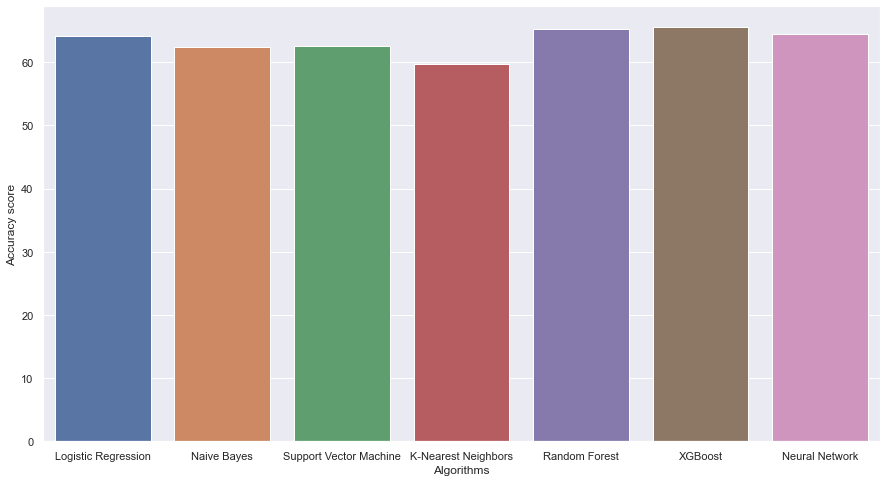

In [95]:
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(algorithms,scores)

The precision score achieved using Logistic Regression is: 26.64 %
The precision score achieved using Naive Bayes is: 43.92 %
The precision score achieved using Support Vector Machine is: 0.0 %
The precision score achieved using K-Nearest Neighbors is: 17.5 %
The precision score achieved using Random Forest is: 29.65 %
The precision score achieved using XGBoost is: 27.09 %
The precision score achieved using Neural Network is: 22.85 %


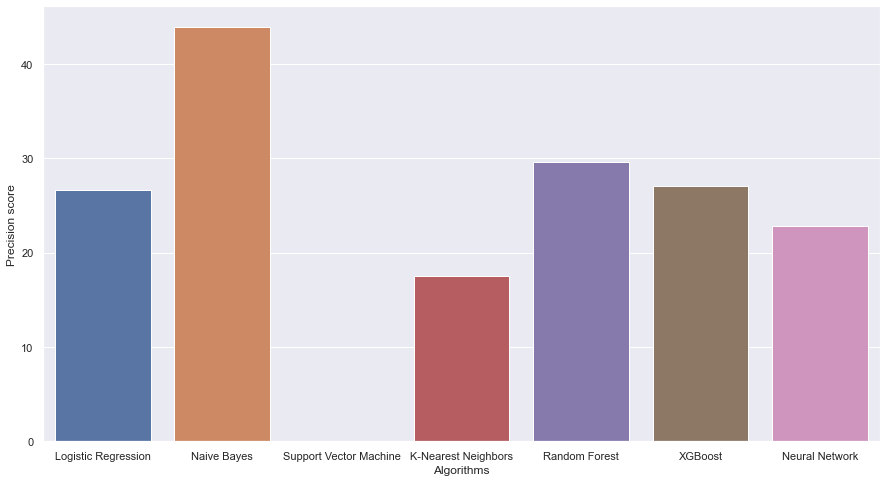

In [111]:
scores = [precision_lr,precision_nb,precision_svm,precision_knn,precision_rf,precision_xgb,precision_nn]
algorithms = ["Logistic Regression","Naive Bayes","Support Vector Machine","K-Nearest Neighbors","Random Forest","XGBoost","Neural Network"]    

for i in range(len(algorithms)):
    print("The precision score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")
    
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Precision score")

sns.barplot(algorithms,scores)

The recall score achieved using Logistic Regression is: 54.32 %
The recall score achieved using Naive Bayes is: 49.68 %
The recall score achieved using Support Vector Machine is: 0.0 %
The recall score achieved using K-Nearest Neighbors is: 40.89 %
The recall score achieved using Random Forest is: 56.12 %
The recall score achieved using XGBoost is: 58.55 %
The recall score achieved using Neural Network is: 56.16 %


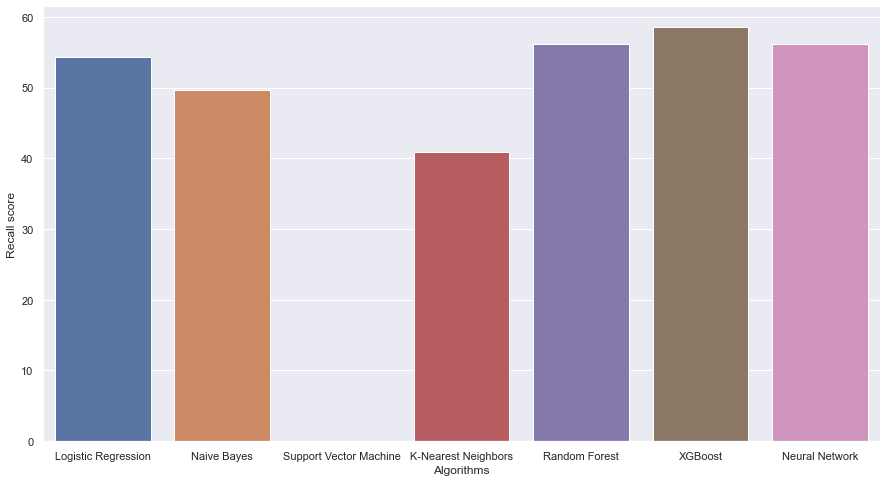

In [108]:
scores = [recall_lr,recall_nb,recall_svm,recall_knn,recall_rf,recall_xgb,recall_nn]
algorithms = ["Logistic Regression","Naive Bayes","Support Vector Machine","K-Nearest Neighbors","Random Forest","XGBoost","Neural Network"]    

for i in range(len(algorithms)):
    print("The recall score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")
    
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Recall score")

sns.barplot(algorithms,scores)

The f1 score achieved using Logistic Regression is: 35.75 %
The f1 score achieved using Naive Bayes is: 46.63 %
The f1 score achieved using Support Vector Machine is: 0.0 %
The f1 score achieved using K-Nearest Neighbors is: 24.51 %
The f1 score achieved using Random Forest is: 38.8 %
The f1 score achieved using XGBoost is: 37.04 %
The f1 score achieved using Neural Network is: 32.49 %


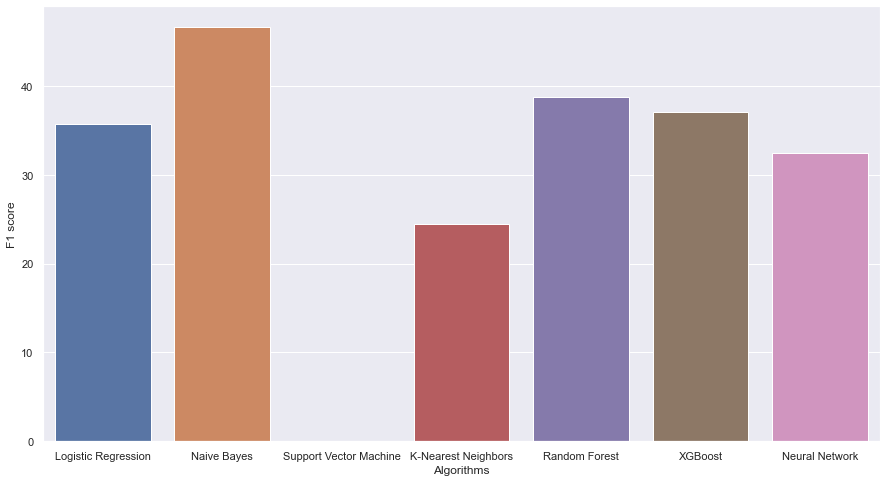

In [110]:
scores = [F1_lr,F1_nb,F1_svm,F1_knn,F1_rf,F1_xgb,F1_nn]
algorithms = ["Logistic Regression","Naive Bayes","Support Vector Machine","K-Nearest Neighbors","Random Forest","XGBoost","Neural Network"]    

for i in range(len(algorithms)):
    print("The f1 score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")
    
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("F1 score")

sns.barplot(algorithms,scores)

## Résumé des scores

[0 1 2 3 4 5]


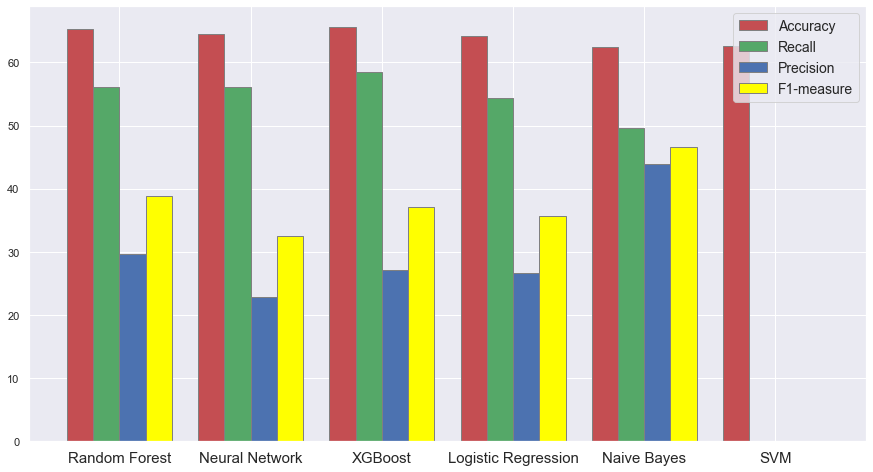

In [112]:
barWidth = 0.2

fig = plt.subplots(figsize=(15, 8))



# set height of bar

Accuracy = [65.21, 64.5, 65.58, 64.21, 62.42, 62.62]

Rappel = [56.12, 56.16, 58.55, 54.32, 49.68, 40.4]

Precision = [29.65, 22.85, 27.09, 26.64, 43.92, 20.83]

Mesure_F1 = [38.8, 32.49, 37.04, 35.75, 46.63, 27.49]




# Set position of bar on X axis

br1 = np.arange(len(Accuracy))

br2 = [x + barWidth for x in br1]

br3 = [x + barWidth for x in br2]

br4 = [x + barWidth for x in br3]

print(br1)



# Make the plot

plt.bar(br1, Accuracy, color='r', width=barWidth,

        edgecolor='grey', label='Accuracy')

plt.bar(br2, Rappel, color='g', width=barWidth,

        edgecolor='grey', label='Recall')

plt.bar(br3, Precision, color='b', width=barWidth,

        edgecolor='grey', label='Precision')

plt.bar(br4, Mesure_F1, color='yellow', width=barWidth,

        edgecolor='grey', label='F1-measure')



# Adding Xticks

plt.xticks([r + 0.1 + barWidth for r in range(len(Accuracy))],

           ['Random Forest', 'Neural Network', 'XGBoost', 'Logistic Regression', 'Naive Bayes', 'SVM'])

plt.xticks(fontsize=15)



plt.legend(prop={'size': 14})

plt.show()

## VII. BONUS

In [40]:
def cluster_df_to_num(df_cons_act,filename):
    """
    Cette fonction permet de générer un dataframe avec des données numériques 
    en appliquant différentes métriques pour chaque feature du dataset 'consumeractions'
    :input: dataframe, dataframe, str
        nous avons comme entrées le dataset 'consumeractions' à transformer numériquemement, et le nom du fichier 
        pour écrire le tableau obtenu
        
    :output: 
        génération d'un fichier csv pour le clustering
    """
    
    L_userId=df_cons_act['userId'].unique()
    n=len(L_userId)
    
    df_num=pd.DataFrame(columns=['userId','emailOpened','emailClicked','productReviewed','searchSite','RCAD','RCP','couponRed','score_event'],index=range(n))
    
    dic_score_events={}
    dic_EO={}
    dic_EC={}
    dic_PR={}
    dic_SS={}
    dic_RCAD={}
    dic_RCP={}
    dic_CP={}
    
    for i in range(len(L_userId)):
        df_num.at[i,'userId']=L_userId[i]
        dic_score_events[L_userId[i]]=0
        dic_EO[L_userId[i]]=0
        dic_EC[L_userId[i]]=0
        dic_PR[L_userId[i]]=0
        dic_SS[L_userId[i]]=0
        dic_RCAD[L_userId[i]]=0
        dic_RCP[L_userId[i]]=0
        dic_CP[L_userId[i]]=0
    
    for i in range(len(df_cons_act)):
        
        event=df_cons_act.iloc[i]['event']
        tokens=event.split()
        
        if "Email" in tokens:
            if "Opened" in tokens:
                dic_EO[df_cons_act.iloc[i]['userId']]+=1
            #email clicked
            else:
                dic_EC[df_cons_act.iloc[i]['userId']]+=1
        if "Product" in tokens: #Product Reviewed
            dic_PR[df_cons_act.iloc[i]['userId']]+=1
        if "Search" in tokens: #Search site
            dic_SS[df_cons_act.iloc[i]['userId']]+=1
        if "Coupon" in tokens:
            if "Request" in tokens:
                if "Print" in tokens:
                    dic_RCP[df_cons_act.iloc[i]['userId']]+=1
                #Request Coupon Add-to-basket
                else:
                    dic_RCAD[df_cons_act.iloc[i]['userId']]+=1
        else:
            dic_CP[df_cons_act.iloc[i]['userId']]+=1
            
        dic_score_events[df_cons_act.iloc[i]['userId']] += score_event(event)

    for keyID in dic_score_events:
        
        df_num.loc[df_num['userId']==keyID,'score_event']=dic_score_events[keyID]
        df_num.loc[df_num['userId']==keyID,'emailOpened']=dic_EO[keyID]
        df_num.loc[df_num['userId']==keyID,'emailClicked']=dic_EC[keyID]
        df_num.loc[df_num['userId']==keyID,'productReviewed']=dic_PR[keyID]
        df_num.loc[df_num['userId']==keyID,'searchSite']=dic_SS[keyID]
        df_num.loc[df_num['userId']==keyID,'RCAD']=dic_RCAD[keyID]
        df_num.loc[df_num['userId']==keyID,'RCP']=dic_RCP[keyID]
        df_num.loc[df_num['userId']==keyID,'couponRed']=dic_CP[keyID]
               

    f = open(filename, 'r+')
    f.truncate(0)
    df_num.to_csv(filename)
    

In [41]:
##### N.B : N'exécuter cette cellule que si vous avait changé les features ou métriques car le calcul prend aussi entre 5-10 minutes. #####


cluster_df_to_num(cons_actions,path+'DS_num_Clustering_Bonus.csv')

In [42]:
df_cluster=importation('DS_num_Clustering_Bonus.csv')
df_cluster.head()

,Unnamed: 0,userId,emailOpened,emailClicked,productReviewed,searchSite,RCAD,RCP,couponRed,score_event
0,0,use_bw7Dd2MM9RLPaulrFsQ1TzdmFsi,10,4,1,0,0,0,15,21
1,1,use_zfO6MmwMKMABup7Fs9E1TzdcfQy,58,9,1,0,16,54,68,518
2,2,use_ejDjloCwQD84hJpLAAs1TzdfSXa,56,13,1,0,1,4,70,114
3,3,use_CAJDPBtqY7NfMHkKbYQ1TzdcUuk,39,17,8,0,60,96,64,994
4,4,use_azRTZAf4XAfhkCMfvQz1TzdppT4,572,10,1,2,0,0,585,603


In [56]:
from sklearn.cluster import KMeans

# Nombre de clusters souhaités
n_clust = 6

# import de l'échantillon
data = df_cluster.drop('userId',axis=1)


In [57]:
#Cluster K-means
model=KMeans(n_clusters=3)
#adapter le modèle de données
model.fit(data)

KMeans(n_clusters=3)

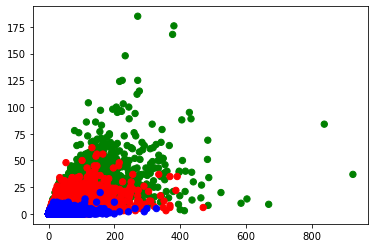

In [60]:
colormap=np.array(['Red','green','blue'])
plt.scatter(data.couponRed, data.emailClicked,c=colormap[model.labels_],s=40)

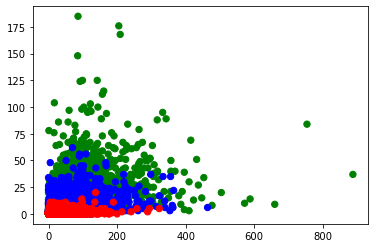

In [51]:
colormap=np.array(['Red','green','blue'])
plt.scatter(data.emailOpened, data.emailClicked,c=colormap[model.labels_],s=40)

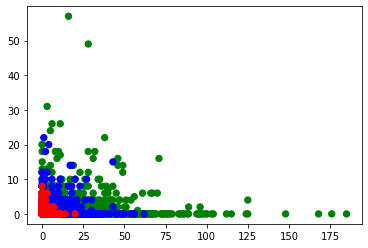

In [53]:
colormap=np.array(['Red','green','blue'])
plt.scatter(data.emailClicked, data.searchSite,c=colormap[model.labels_],s=40)

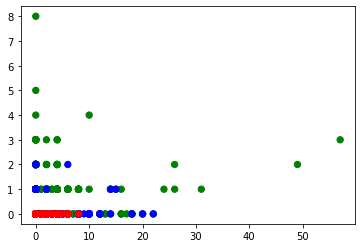

In [55]:
colormap=np.array(['Red','green','blue'])
plt.scatter(data.searchSite, data.productReviewed,c=colormap[model.labels_],s=40)